# Libraries

In [121]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import classification_report
import sklearn.metrics

# Functions

In [122]:
def plot_correlation_map(df):
    corr = df.corr()
    s , ax = plt.subplots(figsize=(12,10))
    cmap = sb.diverging_palette(220,10,as_cmap = True)
    s = sb.heatmap(corr,cmap = cmap,square=True,cbar_kws={ 'shrink' : .9 },ax=ax,
                   annot = True,annot_kws = { 'fontsize' : 12 })

In [11]:
def title(str):
    ch = str.split(',')
    title = ch[1].split('.')
    return title[0]

# Import data

In [7]:
df = pd.read_csv("titanic-passengers.csv",sep=';')
df.info()
df.isnull().sum() # Dataset seem already cleaned
df
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    object 
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Preprocess

Here, I used checkpoint 3 script since we already preprocessed this dataset.

In [17]:
data = df
## Cabin
A=data['Cabin'].mode()[0]
data['Cabin'].fillna(A,inplace=True)
## Embarked
Mostfreq=data.Embarked.value_counts().index[0]
data['Embarked'].fillna(Mostfreq,inplace=True)
one_hot = pd.get_dummies(data.Embarked)
#join one hot encoder
data = data.join(one_hot)
#drop column Embarked
data.drop('Embarked',axis=1, inplace=True)
## Age
data['Age'].fillna(data['Age'].mean(),inplace=True)
## Survived
SurvivedDict = {
    "Survived":{"No":0,"Yes":1}
}
data.replace(SurvivedDict,inplace=True)
## Sex
SexDict = {
    "Sex":{"male":0,"female":1}
}
data.replace(SexDict,inplace=True)
## Add FamSize
data['FamSize'] = data['Parch'] + data['SibSp']

## Add Title
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                     "Dr":         "Officer",
                    "Rev":        "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                   "Lady" :      "Royalty",
                  "the Countess": "Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Miss",
                    "Mlle":       "Miss",
                    "Miss" :      "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mrs",
                    "Mrs" :       "Mrs",
                    "Master" :    "Master"
                    }

data['Title'] = pd.Series(list(map(title,data.Name)))
data['Title'].update(pd.Series(Title_Dictionary))
data.drop('Name',axis=1,inplace=True)
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        891 non-null    object 
 10  C            891 non-null    uint8  
 11  Q            891 non-null    uint8  
 12  S            891 non-null    uint8  
 13  FamSize      891 non-null    int64  
 14  Title        891 non-null    object 
dtypes: float64(2), int64(7), object(3), uint8(3)
memory usage: 86.3+ KB


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S,FamSize,Title
0,343,0,2,0,28.0,0,0,248740,13.0000,B96 B98,0,0,1,0,Mr
1,76,0,3,0,25.0,0,0,348123,7.6500,F G73,0,0,1,0,Mr
2,641,0,3,0,20.0,0,0,350050,7.8542,B96 B98,0,0,1,0,Mr
3,568,0,3,1,29.0,0,4,349909,21.0750,B96 B98,0,0,1,4,Mrs
4,672,0,1,0,31.0,1,0,F.C. 12750,52.0000,B71,0,0,1,1,Mr
5,105,0,3,0,37.0,2,0,3101276,7.9250,B96 B98,0,0,1,2,Mr
6,576,0,3,0,19.0,0,0,358585,14.5000,B96 B98,0,0,1,0,Mr
7,382,1,3,1,1.0,0,2,2653,15.7417,B96 B98,1,0,0,2,Miss
8,228,0,3,0,20.5,0,0,A/5 21173,7.2500,B96 B98,0,0,1,0,Mr
9,433,1,2,1,42.0,1,0,SC/AH 3085,26.0000,B96 B98,0,0,1,1,Mrs


In [21]:
data = data[['PassengerId','Survived','Title','Pclass','Sex','Age',
             'Ticket','Fare','Cabin','C','Q','S','FamSize']]
data

,PassengerId,Survived,Title,Pclass,Sex,Age,Ticket,Fare,Cabin,C,Q,S,FamSize
0,343,0,Mr,2,0,28.000000,248740,13.0000,B96 B98,0,0,1,0
1,76,0,Mr,3,0,25.000000,348123,7.6500,F G73,0,0,1,0
2,641,0,Mr,3,0,20.000000,350050,7.8542,B96 B98,0,0,1,0
3,568,0,Mrs,3,1,29.000000,349909,21.0750,B96 B98,0,0,1,4
4,672,0,Mr,1,0,31.000000,F.C. 12750,52.0000,B71,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,10,1,Mrs,2,1,14.000000,237736,30.0708,B96 B98,1,0,0,1
887,61,0,Mr,3,0,22.000000,2669,7.2292,B96 B98,1,0,0,0
888,535,0,Miss,3,1,30.000000,315084,8.6625,B96 B98,0,0,1,0
889,102,0,Mr,3,0,29.699118,349215,7.8958,B96 B98,0,0,1,0


# Logistic Regression

In [117]:
# define input features
x = data[['Sex','Age','FamSize','Fare']].values
# Target
y = data['Survived'].values

# split data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.35,random_state=1)
# define model
LogReg = LogisticRegression()
# train
LogReg.fit(x_train,y_train)
# predict
y_pred  = LogReg.predict(x_test) 
print("Accuracy =%5.2f"%(LogReg.score(x_test, y_test)))

Accuracy = 0.79


<AxesSubplot:xlabel='Prediction', ylabel='Actual'>

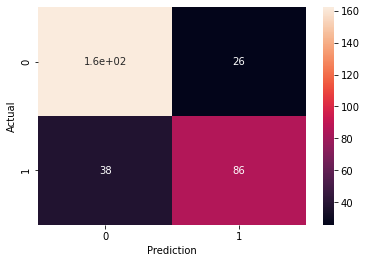

In [118]:
confusion_matrix = pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Prediction'])
sb.heatmap(confusion_matrix, annot=True)

In [124]:
TP = confusion_matrix[1][1]
FP = confusion_matrix[1][0]
TN = confusion_matrix[0][0]
FN = confusion_matrix[0][1]
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Specificity = TN/(TN+FP)
print("Precision =%5.2f \nRecall =%5.2f \nAccuracy =%5.2f \nSpecificity =%5.2f"
      %(Precision,Recall,Accuracy,Specificity))

Precision = 0.77 
Recall = 0.69 
Accuracy = 0.79 
Specificity = 0.86


In [125]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       188
           1       0.77      0.69      0.73       124

    accuracy                           0.79       312
   macro avg       0.79      0.78      0.78       312
weighted avg       0.79      0.79      0.79       312



## ROC-AUC 

Another mesure of the performance of classification models ist the function of the Receiver Operating Characteristics (ROC). This function maps the values of True Positive Rate (TPR) and the values of False Positive Rate (FPR) under the variation of the threshold. The Area Under the Curve (AUC) tells how much the model is predicting positive output correctly (TPR) and also the negative output as negative, that's why the higher this value is, the more accurate is the model. The ideal point is (0,1), where we predict all the positive correctly and we have no false positive, which is in reality impossible. In General, we say that our model performs well if we can move from (0,0) toward (1,0) steeply, without sacrificing much FPR.

![image.PNG](ROC.png)

*source : [https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5]*

Text(0.5, 1.0, 'ROC-Curve')

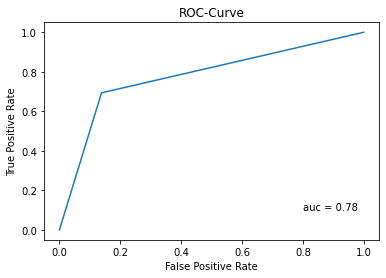

In [123]:
fpr,tpr,threshold = sklearn.metrics.roc_curve(y_test,y_pred)
auc = sklearn.metrics.auc(fpr,tpr)
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.8,0.1,'auc =%5.2f'%(auc))
plt.title('ROC-Curve')